In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

Using Theano backend.


In [2]:
import sys
import os
project_path = os.getcwd() + '/../../'
sys.path.append(project_path + "utils")
sys.path.append(project_path + "data")
sys.path.append(project_path + "multi_models/cnn/")

In [3]:
# utils
import analysis
import function
import other
import local_bayes
import visualize

In [4]:
# data
from base import BaseDataManager
import get_normal_representation 
from preprocessing import Preprocessing
from data import Data

In [5]:
import numpy

In [6]:
from keras.layers import LSTM, GRU, SimpleRNN

## make data

In [161]:
data_name_ls = ['science', 'ajax', 'java', 'news', 'css', 'javascript', 'opensource', 'webdesign', 'design', 'linux', 'photography']
raw_data_dir = project_path + 'original_data/bookmark/'
save_data_dir = project_path + 'data/datasets/bookmark_new/'
train_test_ratio = 0.8
stride = 5
balance = True
output_dim_ls = [6]

base_data_manager = BaseDataManager(raw_data_dir, save_data_dir)
D = Data(raw_data_dir, save_data_dir)
P = Preprocessing(raw_data_dir, save_data_dir)

In [162]:
for output_dim in output_dim_ls:
    
    for data_name in data_name_ls:
        print data_name
        data = base_data_manager.load_data('%s.twd' % data_name)
        ts_ls, ts_sum_ls = get_normal_representation.get_ts_normal_representation(data)
        ts_dict = base_data_manager.div_train_test(ts_ls, train_test_ratio)
        started_ts_dict = base_data_manager.get_started_ts(ts_dict)
        input_ts_dict, label_dict, target_ts_dict, input_sum_dict = \
                                    base_data_manager.make_supervised_data(started_ts_dict, stride, output_dim)
        if balance:
            input_ts_dict, label_dict, target_ts_dict = P.balancing_sampling(input_ts_dict, label_dict, target_ts_dict, output_dim)
            data_type = 'balance'
        else:
            data_type = 'normal'
        D.make_train_data(input_ts_dict, label_dict, target_ts_dict, output_dim, data_type, data_name)

science
ajax
java
news
css
javascript
opensource
webdesign
design
linux
photography


## data load

In [7]:
data_type = 'balance'
output_dim = 6
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [8]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], 1, rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], 1, rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(778, 1, 1, 30)
train samples: 778
test samples: 322


In [9]:
for i in xrange(output_dim):
    all_, sum_ = 0, 0
    for ele in test_ajax['y'][:, i]:
        if abs(ele - 1) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'chance level for dim %s: %s' % (i, sum_ / all_)

chance level for dim 0: 0.704968944099
chance level for dim 1: 0.611801242236
chance level for dim 2: 0.60248447205
chance level for dim 3: 0.549689440994
chance level for dim 4: 0.521739130435
chance level for dim 5: 0.5


## model

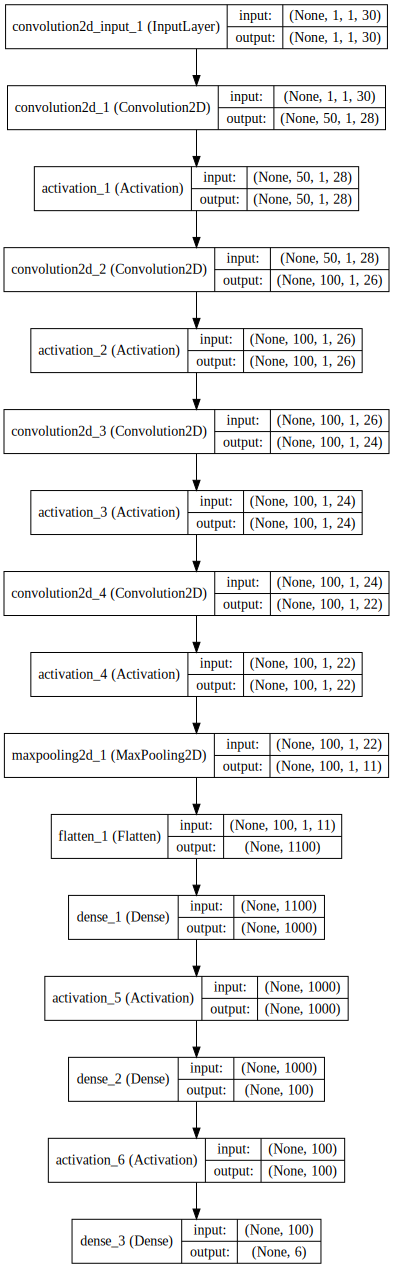

In [10]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
# model.add(Reshape((260, )))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(output_dim = output_dim, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam")

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
nb_epoch = 10
cnn_result = model.fit(x_train, train_ajax['y'], nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.1)

preds = model.predict(x_test)
preds[preds>= 0.5] = 1
preds[preds<0.5] = 0

Train on 700 samples, validate on 78 samples
Epoch 1/10
0s - loss: 0.6719 - val_loss: 0.6494
Epoch 2/10
0s - loss: 0.6222 - val_loss: 0.6467
Epoch 3/10
0s - loss: 0.5976 - val_loss: 0.6545
Epoch 4/10
0s - loss: 0.5814 - val_loss: 0.6818
Epoch 5/10
0s - loss: 0.5715 - val_loss: 0.6762
Epoch 6/10
0s - loss: 0.5476 - val_loss: 0.7362
Epoch 7/10
0s - loss: 0.5233 - val_loss: 0.7376
Epoch 8/10
0s - loss: 0.5010 - val_loss: 0.7376
Epoch 9/10
0s - loss: 0.4788 - val_loss: 0.8278
Epoch 10/10
0s - loss: 0.4464 - val_loss: 0.8466


In [231]:
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test_ajax['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'accuracy for %s th dim: %s' % (i, sum_ / all_)

accuracy for 0 th dim: 0.72049689441
accuracy for 1 th dim: 0.621118012422
accuracy for 2 th dim: 0.633540372671
accuracy for 3 th dim: 0.577639751553
accuracy for 4 th dim: 0.586956521739
accuracy for 5 th dim: 0.555900621118


In [ ]:
preds

In [112]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 0], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

IndexError: invalid index to scalar variable.

In [97]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 1], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/10
0s - loss: 0.6859 - acc: 0.6356 - val_loss: 0.6326 - val_acc: 0.6879
Epoch 2/10
0s - loss: 0.6165 - acc: 0.6841 - val_loss: 0.6236 - val_acc: 0.6636
Epoch 3/10
0s - loss: 0.5928 - acc: 0.6909 - val_loss: 0.6103 - val_acc: 0.7000
Epoch 4/10
0s - loss: 0.5768 - acc: 0.7061 - val_loss: 0.6132 - val_acc: 0.6667
Epoch 5/10
0s - loss: 0.5621 - acc: 0.7144 - val_loss: 0.6779 - val_acc: 0.5636
Epoch 6/10
0s - loss: 0.5638 - acc: 0.7061 - val_loss: 0.6082 - val_acc: 0.7061
Epoch 7/10
0s - loss: 0.5626 - acc: 0.7144 - val_loss: 0.5997 - val_acc: 0.7000
Epoch 8/10
0s - loss: 0.5482 - acc: 0.7136 - val_loss: 0.5946 - val_acc: 0.7061
Epoch 9/10
0s - loss: 0.5396 - acc: 0.7076 - val_loss: 0.6573 - val_acc: 0.6909
Epoch 10/10
0s - loss: 0.5369 - acc: 0.7235 - val_loss: 0.6083 - val_acc: 0.6818


In [98]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 1], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.646138517062
test accuracy: 0.6625


In [99]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 2], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/10
0s - loss: 0.6736 - acc: 0.6045 - val_loss: 0.6366 - val_acc: 0.6424
Epoch 2/10
0s - loss: 0.6172 - acc: 0.6818 - val_loss: 0.6334 - val_acc: 0.6273
Epoch 3/10
0s - loss: 0.5992 - acc: 0.6864 - val_loss: 0.6172 - val_acc: 0.6394
Epoch 4/10
0s - loss: 0.5776 - acc: 0.6977 - val_loss: 0.6503 - val_acc: 0.6515
Epoch 5/10
0s - loss: 0.5749 - acc: 0.7015 - val_loss: 0.6268 - val_acc: 0.6333
Epoch 6/10
0s - loss: 0.5602 - acc: 0.7091 - val_loss: 0.6247 - val_acc: 0.6364
Epoch 7/10
0s - loss: 0.5544 - acc: 0.7106 - val_loss: 0.6504 - val_acc: 0.5879
Epoch 8/10
0s - loss: 0.5483 - acc: 0.7106 - val_loss: 0.6741 - val_acc: 0.6152
Epoch 9/10
0s - loss: 0.5321 - acc: 0.7417 - val_loss: 0.6328 - val_acc: 0.6576
Epoch 10/10
0s - loss: 0.5325 - acc: 0.7356 - val_loss: 0.6414 - val_acc: 0.6485


In [100]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 2], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.677830870946
test accuracy: 0.620833333333


## RNN

### data load for RNN

In [204]:
data_type = 'balance'
output_dim = 5
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [209]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(1091, 1, 30)
train samples: 1091
test samples: 287


### model

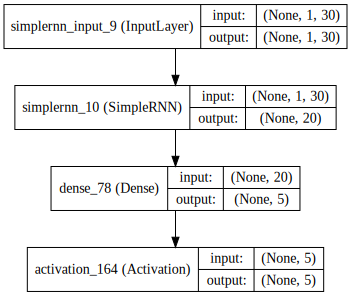

In [212]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=False, input_shape=(rows, cols)))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [215]:
nb_epoch = 200
simple = model.fit(x_train, y_train, batch_size=50, nb_epoch=nb_epoch,
                   validation_split=0.1)

preds = model.predict(x_test)
preds[preds>= 0.5] = 1
preds[preds<0.5] = 0

Train on 981 samples, validate on 110 samples
Epoch 1/200
981/981 [==============================] - 0s - loss: 0.5464 - acc: 0.5607 - val_loss: 0.6406 - val_acc: 0.5000
Epoch 2/200
981/981 [==============================] - 0s - loss: 0.5462 - acc: 0.5464 - val_loss: 0.6403 - val_acc: 0.5000
Epoch 3/200
981/981 [==============================] - 0s - loss: 0.5460 - acc: 0.5494 - val_loss: 0.6404 - val_acc: 0.5091
Epoch 4/200
981/981 [==============================] - 0s - loss: 0.5458 - acc: 0.5464 - val_loss: 0.6400 - val_acc: 0.5273
Epoch 5/200
981/981 [==============================] - 0s - loss: 0.5456 - acc: 0.5617 - val_loss: 0.6404 - val_acc: 0.5182
Epoch 6/200
981/981 [==============================] - 0s - loss: 0.5453 - acc: 0.5474 - val_loss: 0.6406 - val_acc: 0.5455
Epoch 7/200
981/981 [==============================] - 0s - loss: 0.5452 - acc: 0.5505 - val_loss: 0.6403 - val_acc: 0.5273
Epoch 8/200
981/981 [==============================] - 0s - loss: 0.5449 - acc: 0.5433

In [214]:
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test_ajax['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'accuracy for %s th dim: %s' % (i, sum_ / all_)

accuracy for 0 th dim: 0.721254355401
accuracy for 1 th dim: 0.672473867596
accuracy for 2 th dim: 0.623693379791
accuracy for 3 th dim: 0.613240418118
accuracy for 4 th dim: 0.550522648084


## GRU

### data load for GRU

In [216]:
data_type = 'balance'
output_dim = 6
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [217]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(778, 1, 30)
train samples: 778
test samples: 322


### model

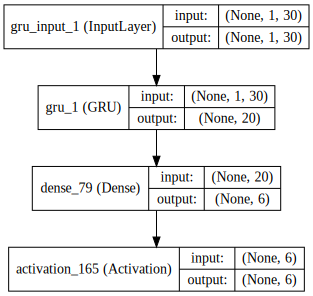

In [218]:
model = Sequential()
model.add(GRU(20, return_sequences=False, input_shape=(rows, cols)))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [219]:
nb_epoch = 200
simple = model.fit(x_train, y_train, batch_size=50, nb_epoch=nb_epoch,
                   validation_split=0.1)

preds = model.predict(x_test)
preds[preds>= 0.5] = 1
preds[preds<0.5] = 0

Train on 700 samples, validate on 78 samples
Epoch 1/200
700/700 [==============================] - 0s - loss: 0.7396 - acc: 0.0514 - val_loss: 0.7182 - val_acc: 0.0385
Epoch 2/200
700/700 [==============================] - 0s - loss: 0.7194 - acc: 0.0686 - val_loss: 0.7031 - val_acc: 0.0385
Epoch 3/200
700/700 [==============================] - 0s - loss: 0.7054 - acc: 0.1000 - val_loss: 0.6905 - val_acc: 0.1282
Epoch 4/200
700/700 [==============================] - 0s - loss: 0.6941 - acc: 0.1457 - val_loss: 0.6803 - val_acc: 0.1795
Epoch 5/200
700/700 [==============================] - 0s - loss: 0.6844 - acc: 0.1971 - val_loss: 0.6725 - val_acc: 0.3077
Epoch 6/200
700/700 [==============================] - 0s - loss: 0.6764 - acc: 0.2471 - val_loss: 0.6658 - val_acc: 0.3718
Epoch 7/200
700/700 [==============================] - 0s - loss: 0.6700 - acc: 0.3029 - val_loss: 0.6602 - val_acc: 0.4103
Epoch 8/200
700/700 [==============================] - 0s - loss: 0.6645 - acc: 0.3700 

In [220]:
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test_ajax['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'accuracy for %s th dim: %s' % (i, sum_ / all_)

accuracy for 0 th dim: 0.72049689441
accuracy for 1 th dim: 0.621118012422
accuracy for 2 th dim: 0.60248447205
accuracy for 3 th dim: 0.571428571429
accuracy for 4 th dim: 0.574534161491
accuracy for 5 th dim: 0.509316770186


## LSTM

### data load for LSTM

In [221]:
data_type = 'balance'
output_dim = 6
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [222]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(778, 1, 30)
train samples: 778
test samples: 322


### model

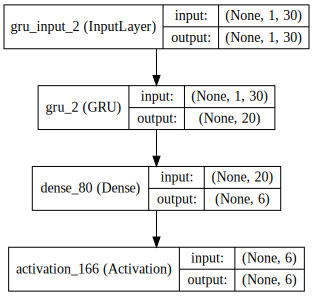

In [223]:
model = Sequential()
model.add(GRU(20, return_sequences=False, input_shape=(rows, cols)))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [224]:
nb_epoch = 200
simple = model.fit(x_train, y_train, batch_size=50, nb_epoch=nb_epoch,
                   validation_split=0.1)

preds = model.predict(x_test)
preds[preds>= 0.5] = 1
preds[preds<0.5] = 0

Train on 700 samples, validate on 78 samples
Epoch 1/200
700/700 [==============================] - 0s - loss: 0.7068 - acc: 0.2643 - val_loss: 0.7133 - val_acc: 0.3333
Epoch 2/200
700/700 [==============================] - 0s - loss: 0.6954 - acc: 0.2943 - val_loss: 0.7078 - val_acc: 0.3718
Epoch 3/200
700/700 [==============================] - 0s - loss: 0.6863 - acc: 0.3200 - val_loss: 0.7036 - val_acc: 0.4359
Epoch 4/200
700/700 [==============================] - 0s - loss: 0.6790 - acc: 0.3571 - val_loss: 0.6989 - val_acc: 0.4744
Epoch 5/200
700/700 [==============================] - 0s - loss: 0.6736 - acc: 0.3814 - val_loss: 0.6952 - val_acc: 0.4872
Epoch 6/200
700/700 [==============================] - 0s - loss: 0.6692 - acc: 0.4029 - val_loss: 0.6924 - val_acc: 0.5256
Epoch 7/200
700/700 [==============================] - 0s - loss: 0.6653 - acc: 0.4100 - val_loss: 0.6903 - val_acc: 0.5769
Epoch 8/200
700/700 [==============================] - 0s - loss: 0.6618 - acc: 0.4386 

In [225]:
for i in xrange(output_dim):
    pred = preds[:, i]
    ans = test_ajax['y'][:, i]
    sum_, all_ = 0, 0
    for pred_, ans_ in zip(pred, ans):
        if abs(pred_ - ans_) == 0:
            sum_ += 1.0
        all_ += 1.0
    print 'accuracy for %s th dim: %s' % (i, sum_ / all_)

accuracy for 0 th dim: 0.72049689441
accuracy for 1 th dim: 0.621118012422
accuracy for 2 th dim: 0.605590062112
accuracy for 3 th dim: 0.574534161491
accuracy for 4 th dim: 0.568322981366
accuracy for 5 th dim: 0.537267080745
